In [ ]:
%matplotlib inline


Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [ ]:
# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

# trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
#                                         download=True, transform=transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
#                                           shuffle=True, num_workers=2)

# testset = torchvision.datasets.CIFAR10(root='./data', train=False,
#                                        download=True, transform=transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=128,
#                                          shuffle=False, num_workers=2)

# classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
!pip install git+https://github.com/albumentations-team/albumentations.git

  Cloning https://github.com/albumentations-team/albumentations.git to /tmp/pip-req-build-z9tcmh65
  Running command git clone -q https://github.com/albumentations-team/albumentations.git /tmp/pip-req-build-z9tcmh65
  Created wheel for albumentations: filename=albumentations-1.0.0-cp37-none-any.whl size=98151 sha256=cafca329a7a7c4314f2e9a4430ebc0dc7a84ba6ff35b8b14537adfdc571d6e51
  Stored in directory: /tmp/pip-ephem-wheel-cache-x68n7xwk/wheels/e2/85/3e/2a40fac5cc1f43ced656603bb2fca1327b30ec7de1b1b66517
Successfully built albumentations


In [ ]:
# Reference https://albumentations.ai/docs/autoalbument/examples/cifar10/

class Cifar10SearchDataset(torchvision.datasets.CIFAR10):
    def __init__(self, root="~/data/cifar10", train=True, download=True, transform=None):
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image, label

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

mean, std = (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)

train_transform = A.Compose(
    [
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=5, p=0.5),
        A.HorizontalFlip(p=0.5),
        A.CoarseDropout(max_holes = 1, max_height=16, max_width=16, min_holes = 1,
                        min_height=16, min_width=16,
                        fill_value=mean, mask_fill_value = None),
        A.Normalize(mean, std),
        ToTensorV2(),
    ]
)

test_transform = A.Compose(
    [
        A.Normalize(mean, std),
        ToTensorV2(),
    ]
)

trainset = Cifar10SearchDataset(root='./data', train=True,
                                        download=True, transform=train_transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testset = Cifar10SearchDataset(root='./data', train=False,
                                       download=True, transform=test_transform)

testloader =torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  car  bird  bird  ship


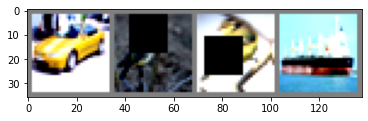

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

2. Define a Convolution Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
from model import Net

In [ ]:
!pip install torchsummary
from torchsummary import summary

model = Net().to(device)  # Create model
summary(model, input_size=(3, 32, 32))  # Display model summary

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
            Conv2d-4           [-1, 32, 32, 32]           9,248
              ReLU-5           [-1, 32, 32, 32]               0
       BatchNorm2d-6           [-1, 32, 32, 32]              64
            Conv2d-7           [-1, 32, 32, 32]           9,248
              ReLU-8           [-1, 32, 32, 32]               0
       BatchNorm2d-9           [-1, 32, 32, 32]              64
        Dropout2d-10           [-1, 32, 32, 32]               0
           Conv2d-11           [-1, 32, 16, 16]           9,248
             ReLU-12           [-1, 32, 16, 16]               0
      BatchNorm2d-13           [-1, 32, 16, 16]              64
           Conv2d-14           [-1, 32,

3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

Train and Test functions

In [ ]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    train_loss = 0
    correct = 0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        #loss = F.nll_loss(output, target)
        loss = criterion(output, target) 
        train_loss += loss.item()       
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')        
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

    train_loss /= len(train_loader.dataset)
    print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        train_loss, correct, len(train_loader.dataset),
        100. * correct / len(train_loader.dataset)))
    return train_loss, 100.*correct/len(train_loader.dataset)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss, 100.*correct/len(test_loader.dataset)

4. Train the network
^^^^^^^^^^^^^^^^^^^^

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [ ]:
# for epoch in range(2):  # loop over the dataset multiple times

#     running_loss = 0.0
#     for i, data in enumerate(trainloader, 0):
#         # get the inputs
#         inputs, labels = data

#         inputs, labels = inputs.to(device), labels.to(device)

#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         outputs = net(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         # print statistics
#         running_loss += loss.item()
#         if i % 2000 == 1999:    # print every 2000 mini-batches
#             print('[%d, %5d] loss: %.3f' %
#                   (epoch + 1, i + 1, running_loss / 2000))
#             running_loss = 0.0

# print('Finished Training')

In [ ]:
from torch.optim.lr_scheduler import StepLR,OneCycleLR

#model = Net().to(device)
lr = 0.01
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
#optimizer = optim.Adam(model.parameters(), lr=lr)

train_loss_list = []
test_loss_list = []
train_accuracy_list=[]
test_accuracy_list=[]

#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = OneCycleLR(optimizer, max_lr=0.1,epochs=100,steps_per_epoch=len(trainloader))

for epoch in range(0, 100):
    print(f"Epoch {epoch}")
    # if(epoch % 4 == 0):
    #   lr = lr/10
    #   optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    #if(epoch==25):
    #  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.7)

    #if(epoch==40):
    #  optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
    
    train_loss,train_acc = train(model, device, trainloader, optimizer, epoch)
    #scheduler.step()
    test_loss,test_acc = test(model, device, testloader)

    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)

    train_accuracy_list.append(train_acc)
    test_accuracy_list.append(test_acc)

  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 0


loss=1.7257423400878906 batch_id=390: 100%|██████████| 391/391 [00:11<00:00, 33.08it/s]


Train set: Average loss: 0.0150, Accuracy: 13900/50000 (27.80%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -1.6271, Accuracy: 3962/10000 (39.62%)

Epoch 1


loss=1.4534690380096436 batch_id=390: 100%|██████████| 391/391 [00:11<00:00, 33.18it/s]



Train set: Average loss: 0.0124, Accuracy: 20506/50000 (41.01%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -2.4014, Accuracy: 5000/10000 (50.00%)

Epoch 2


loss=1.292593240737915 batch_id=390: 100%|██████████| 391/391 [00:11<00:00, 32.84it/s]


Train set: Average loss: 0.0112, Accuracy: 23650/50000 (47.30%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -2.8563, Accuracy: 5459/10000 (54.59%)

Epoch 3


loss=1.3634364604949951 batch_id=390: 100%|██████████| 391/391 [00:11<00:00, 32.62it/s]


Train set: Average loss: 0.0103, Accuracy: 26079/50000 (52.16%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -3.3096, Accuracy: 5930/10000 (59.30%)

Epoch 4


loss=1.217454433441162 batch_id=390: 100%|██████████| 391/391 [00:11<00:00, 32.82it/s]


Train set: Average loss: 0.0095, Accuracy: 27911/50000 (55.82%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -3.8739, Accuracy: 6317/10000 (63.17%)

Epoch 5


loss=1.018296241760254 batch_id=390: 100%|██████████| 391/391 [00:11<00:00, 32.73it/s]


Train set: Average loss: 0.0088, Accuracy: 29683/50000 (59.37%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -4.1418, Accuracy: 6741/10000 (67.41%)

Epoch 6


loss=0.7722252607345581 batch_id=390: 100%|██████████| 391/391 [00:11<00:00, 33.08it/s]


Train set: Average loss: 0.0083, Accuracy: 31121/50000 (62.24%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -4.5612, Accuracy: 7134/10000 (71.34%)

Epoch 7


loss=0.9918448328971863 batch_id=390: 100%|██████████| 391/391 [00:11<00:00, 33.06it/s]


Train set: Average loss: 0.0079, Accuracy: 32156/50000 (64.31%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -4.5259, Accuracy: 7133/10000 (71.33%)

Epoch 8


loss=1.2742197513580322 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 32.35it/s]


Train set: Average loss: 0.0077, Accuracy: 32728/50000 (65.46%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -4.9436, Accuracy: 7321/10000 (73.21%)

Epoch 9


loss=0.9134820699691772 batch_id=390: 100%|██████████| 391/391 [00:11<00:00, 32.63it/s]


Train set: Average loss: 0.0074, Accuracy: 33398/50000 (66.80%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -5.0684, Accuracy: 7378/10000 (73.78%)

Epoch 10


loss=0.9060899615287781 batch_id=390: 100%|██████████| 391/391 [00:11<00:00, 32.93it/s]


Train set: Average loss: 0.0071, Accuracy: 34151/50000 (68.30%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -5.4642, Accuracy: 7418/10000 (74.18%)

Epoch 11


loss=0.9785834550857544 batch_id=390: 100%|██████████| 391/391 [00:11<00:00, 32.65it/s]


Train set: Average loss: 0.0070, Accuracy: 34404/50000 (68.81%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -5.3456, Accuracy: 7611/10000 (76.11%)

Epoch 12


loss=0.9768499135971069 batch_id=390: 100%|██████████| 391/391 [00:11<00:00, 33.01it/s]


Train set: Average loss: 0.0068, Accuracy: 34649/50000 (69.30%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -5.4728, Accuracy: 7627/10000 (76.27%)

Epoch 13


loss=0.7189508676528931 batch_id=390: 100%|██████████| 391/391 [00:11<00:00, 32.90it/s]


Train set: Average loss: 0.0066, Accuracy: 35128/50000 (70.26%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -5.7332, Accuracy: 7730/10000 (77.30%)

Epoch 14


loss=0.8413866758346558 batch_id=390: 100%|██████████| 391/391 [00:11<00:00, 32.76it/s]


Train set: Average loss: 0.0065, Accuracy: 35628/50000 (71.26%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -5.8217, Accuracy: 7790/10000 (77.90%)

Epoch 15


loss=0.7065805196762085 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 32.52it/s]



Train set: Average loss: 0.0064, Accuracy: 35821/50000 (71.64%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.0563, Accuracy: 7820/10000 (78.20%)

Epoch 16


loss=1.053808331489563 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 32.48it/s]


Train set: Average loss: 0.0063, Accuracy: 35869/50000 (71.74%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.0616, Accuracy: 7903/10000 (79.03%)

Epoch 17


loss=0.7390432953834534 batch_id=390: 100%|██████████| 391/391 [00:11<00:00, 32.74it/s]


Train set: Average loss: 0.0062, Accuracy: 36166/50000 (72.33%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.1779, Accuracy: 7889/10000 (78.89%)

Epoch 18


loss=0.9596093893051147 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 32.56it/s]


Train set: Average loss: 0.0061, Accuracy: 36425/50000 (72.85%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.2180, Accuracy: 7949/10000 (79.49%)

Epoch 19


loss=0.7086213827133179 batch_id=390: 100%|██████████| 391/391 [00:11<00:00, 32.83it/s]


Train set: Average loss: 0.0060, Accuracy: 36685/50000 (73.37%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.4315, Accuracy: 8002/10000 (80.02%)

Epoch 20


loss=0.7901852130889893 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 32.56it/s]


Train set: Average loss: 0.0059, Accuracy: 36784/50000 (73.57%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.1944, Accuracy: 7957/10000 (79.57%)

Epoch 21


loss=0.8170426487922668 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 32.24it/s]


Train set: Average loss: 0.0058, Accuracy: 36986/50000 (73.97%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.7189, Accuracy: 7896/10000 (78.96%)

Epoch 22


loss=0.787946343421936 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 32.48it/s]


Train set: Average loss: 0.0058, Accuracy: 36962/50000 (73.92%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.6310, Accuracy: 7878/10000 (78.78%)

Epoch 23


loss=0.6597152948379517 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 32.55it/s]


Train set: Average loss: 0.0057, Accuracy: 37263/50000 (74.53%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.4428, Accuracy: 8100/10000 (81.00%)

Epoch 24


loss=0.848138153553009 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 32.32it/s]


Train set: Average loss: 0.0056, Accuracy: 37397/50000 (74.79%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.6750, Accuracy: 8009/10000 (80.09%)

Epoch 25


loss=0.7748172879219055 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 32.44it/s]


Train set: Average loss: 0.0056, Accuracy: 37625/50000 (75.25%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.8027, Accuracy: 8145/10000 (81.45%)

Epoch 26


loss=0.6711636781692505 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 32.26it/s]



Train set: Average loss: 0.0056, Accuracy: 37576/50000 (75.15%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.6535, Accuracy: 8009/10000 (80.09%)

Epoch 27


loss=0.8271262049674988 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 32.21it/s]


Train set: Average loss: 0.0055, Accuracy: 37711/50000 (75.42%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.8311, Accuracy: 8138/10000 (81.38%)

Epoch 28


loss=0.7694693803787231 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.87it/s]


Train set: Average loss: 0.0054, Accuracy: 37848/50000 (75.70%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.7119, Accuracy: 8144/10000 (81.44%)

Epoch 29


loss=0.5041437149047852 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 32.34it/s]


Train set: Average loss: 0.0054, Accuracy: 38035/50000 (76.07%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.8854, Accuracy: 8162/10000 (81.62%)

Epoch 30


loss=0.592350959777832 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 32.30it/s]


Train set: Average loss: 0.0053, Accuracy: 38136/50000 (76.27%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.7155, Accuracy: 8147/10000 (81.47%)

Epoch 31


loss=0.7241195440292358 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.91it/s]


Train set: Average loss: 0.0053, Accuracy: 38270/50000 (76.54%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.0661, Accuracy: 8226/10000 (82.26%)

Epoch 32


loss=0.7608484029769897 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.89it/s]


Train set: Average loss: 0.0052, Accuracy: 38322/50000 (76.64%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.9864, Accuracy: 8257/10000 (82.57%)

Epoch 33


loss=0.5988112688064575 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.21it/s]


Train set: Average loss: 0.0052, Accuracy: 38376/50000 (76.75%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.2246, Accuracy: 8264/10000 (82.64%)

Epoch 34


loss=0.57245934009552 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.40it/s]


Train set: Average loss: 0.0052, Accuracy: 38448/50000 (76.90%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.9993, Accuracy: 8275/10000 (82.75%)

Epoch 35


loss=0.799145519733429 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.27it/s]


Train set: Average loss: 0.0051, Accuracy: 38534/50000 (77.07%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.7533, Accuracy: 8270/10000 (82.70%)

Epoch 36


loss=0.6685396432876587 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.82it/s]


Train set: Average loss: 0.0051, Accuracy: 38581/50000 (77.16%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.2519, Accuracy: 8311/10000 (83.11%)

Epoch 37


loss=0.5306111574172974 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.94it/s]


Train set: Average loss: 0.0051, Accuracy: 38749/50000 (77.50%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.1906, Accuracy: 8347/10000 (83.47%)

Epoch 38


loss=0.6357524991035461 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.43it/s]


Train set: Average loss: 0.0050, Accuracy: 38842/50000 (77.68%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.1658, Accuracy: 8284/10000 (82.84%)

Epoch 39


loss=0.6418769955635071 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.98it/s]


Train set: Average loss: 0.0050, Accuracy: 38943/50000 (77.89%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.6002, Accuracy: 8328/10000 (83.28%)

Epoch 40


loss=0.5746569633483887 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.06it/s]


Train set: Average loss: 0.0050, Accuracy: 38917/50000 (77.83%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.5026, Accuracy: 8308/10000 (83.08%)

Epoch 41


loss=0.5898503065109253 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.06it/s]


Train set: Average loss: 0.0049, Accuracy: 39065/50000 (78.13%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.3121, Accuracy: 8335/10000 (83.35%)

Epoch 42


loss=0.8024464845657349 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.05it/s]


Train set: Average loss: 0.0049, Accuracy: 39204/50000 (78.41%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.5624, Accuracy: 8376/10000 (83.76%)

Epoch 43


loss=0.5043795704841614 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.88it/s]


Train set: Average loss: 0.0049, Accuracy: 39262/50000 (78.52%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.4410, Accuracy: 8390/10000 (83.90%)

Epoch 44


loss=0.5882308483123779 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.13it/s]


Train set: Average loss: 0.0048, Accuracy: 39188/50000 (78.38%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.5747, Accuracy: 8399/10000 (83.99%)

Epoch 45


loss=0.7009183168411255 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.55it/s]


Train set: Average loss: 0.0048, Accuracy: 39302/50000 (78.60%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.8247, Accuracy: 8346/10000 (83.46%)

Epoch 46


loss=0.48845916986465454 batch_id=390: 100%|██████████| 391/391 [00:13<00:00, 29.10it/s]


Train set: Average loss: 0.0048, Accuracy: 39368/50000 (78.74%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.7402, Accuracy: 8357/10000 (83.57%)

Epoch 47


loss=0.7937819361686707 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.56it/s]


Train set: Average loss: 0.0047, Accuracy: 39529/50000 (79.06%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.6820, Accuracy: 8401/10000 (84.01%)

Epoch 48


loss=0.548721194267273 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.56it/s]


Train set: Average loss: 0.0048, Accuracy: 39372/50000 (78.74%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.7336, Accuracy: 8385/10000 (83.85%)

Epoch 49


loss=0.6344097256660461 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 32.01it/s]


Train set: Average loss: 0.0048, Accuracy: 39413/50000 (78.83%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.5112, Accuracy: 8380/10000 (83.80%)

Epoch 50


loss=0.5183349251747131 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.73it/s]


Train set: Average loss: 0.0047, Accuracy: 39588/50000 (79.18%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.7354, Accuracy: 8359/10000 (83.59%)

Epoch 51


loss=0.5305629968643188 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.77it/s]


Train set: Average loss: 0.0047, Accuracy: 39719/50000 (79.44%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.5697, Accuracy: 8443/10000 (84.43%)

Epoch 52


loss=0.5122157335281372 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.62it/s]


Train set: Average loss: 0.0046, Accuracy: 39665/50000 (79.33%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.6855, Accuracy: 8473/10000 (84.73%)

Epoch 53


loss=0.4839867055416107 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.09it/s]



Train set: Average loss: 0.0046, Accuracy: 39785/50000 (79.57%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.6387, Accuracy: 8482/10000 (84.82%)

Epoch 54


loss=0.752980649471283 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.73it/s]


Train set: Average loss: 0.0046, Accuracy: 39734/50000 (79.47%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.8920, Accuracy: 8473/10000 (84.73%)

Epoch 55


loss=0.5431578755378723 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.45it/s]


Train set: Average loss: 0.0046, Accuracy: 39866/50000 (79.73%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.0550, Accuracy: 8437/10000 (84.37%)

Epoch 56


loss=0.5553421974182129 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.66it/s]


Train set: Average loss: 0.0046, Accuracy: 39983/50000 (79.97%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.7535, Accuracy: 8468/10000 (84.68%)

Epoch 57


loss=0.5873116254806519 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.90it/s]


Train set: Average loss: 0.0045, Accuracy: 39972/50000 (79.94%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.0522, Accuracy: 8528/10000 (85.28%)

Epoch 58


loss=1.0268352031707764 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.32it/s]


Train set: Average loss: 0.0045, Accuracy: 39995/50000 (79.99%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.0154, Accuracy: 8444/10000 (84.44%)

Epoch 59


loss=0.6059767007827759 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.59it/s]


Train set: Average loss: 0.0045, Accuracy: 40077/50000 (80.15%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.7472, Accuracy: 8492/10000 (84.92%)

Epoch 60


loss=0.7996971607208252 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.37it/s]


Train set: Average loss: 0.0045, Accuracy: 40165/50000 (80.33%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.8908, Accuracy: 8512/10000 (85.12%)

Epoch 61


loss=0.46453914046287537 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.61it/s]


Train set: Average loss: 0.0044, Accuracy: 40262/50000 (80.52%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.9638, Accuracy: 8517/10000 (85.17%)

Epoch 62


loss=0.5068780183792114 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.70it/s]


Train set: Average loss: 0.0044, Accuracy: 40136/50000 (80.27%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.9929, Accuracy: 8503/10000 (85.03%)

Epoch 63


loss=0.5380634069442749 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.49it/s]


Train set: Average loss: 0.0044, Accuracy: 40209/50000 (80.42%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.8566, Accuracy: 8464/10000 (84.64%)

Epoch 64


loss=0.588861346244812 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.52it/s]


Train set: Average loss: 0.0044, Accuracy: 40341/50000 (80.68%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.0663, Accuracy: 8551/10000 (85.51%)

Epoch 65


loss=0.47439733147621155 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.34it/s]


Train set: Average loss: 0.0044, Accuracy: 40239/50000 (80.48%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.9280, Accuracy: 8544/10000 (85.44%)

Epoch 66


loss=0.6168339848518372 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.54it/s]


Train set: Average loss: 0.0043, Accuracy: 40411/50000 (80.82%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.1537, Accuracy: 8532/10000 (85.32%)

Epoch 67


loss=0.6368600726127625 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.06it/s]


Train set: Average loss: 0.0044, Accuracy: 40374/50000 (80.75%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.1993, Accuracy: 8531/10000 (85.31%)

Epoch 68


loss=0.5145284533500671 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.26it/s]


Train set: Average loss: 0.0043, Accuracy: 40541/50000 (81.08%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.9827, Accuracy: 8491/10000 (84.91%)

Epoch 69


loss=0.5451110601425171 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.28it/s]


Train set: Average loss: 0.0042, Accuracy: 40596/50000 (81.19%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.3040, Accuracy: 8541/10000 (85.41%)

Epoch 70


loss=0.691919207572937 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.80it/s]


Train set: Average loss: 0.0043, Accuracy: 40533/50000 (81.07%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.1294, Accuracy: 8568/10000 (85.68%)

Epoch 71


loss=0.5814695358276367 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.42it/s]


Train set: Average loss: 0.0042, Accuracy: 40715/50000 (81.43%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.1398, Accuracy: 8595/10000 (85.95%)

Epoch 72


loss=0.5553327798843384 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.15it/s]


Train set: Average loss: 0.0042, Accuracy: 40724/50000 (81.45%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.1615, Accuracy: 8544/10000 (85.44%)

Epoch 73


loss=0.6894186735153198 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.92it/s]


Train set: Average loss: 0.0042, Accuracy: 40602/50000 (81.20%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.2864, Accuracy: 8594/10000 (85.94%)

Epoch 74


loss=0.47837910056114197 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.93it/s]


Train set: Average loss: 0.0042, Accuracy: 40746/50000 (81.49%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.3373, Accuracy: 8582/10000 (85.82%)

Epoch 75


loss=0.5276978015899658 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.83it/s]


Train set: Average loss: 0.0042, Accuracy: 40666/50000 (81.33%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.4122, Accuracy: 8550/10000 (85.50%)

Epoch 76


loss=0.7147855162620544 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.93it/s]


Train set: Average loss: 0.0041, Accuracy: 40991/50000 (81.98%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.6025, Accuracy: 8589/10000 (85.89%)

Epoch 77


loss=0.48315945267677307 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.92it/s]


Train set: Average loss: 0.0041, Accuracy: 40957/50000 (81.91%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.5601, Accuracy: 8611/10000 (86.11%)

Epoch 78


loss=0.5850645899772644 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.62it/s]


Train set: Average loss: 0.0041, Accuracy: 41021/50000 (82.04%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.4212, Accuracy: 8632/10000 (86.32%)

Epoch 79


loss=0.37920188903808594 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.85it/s]


Train set: Average loss: 0.0041, Accuracy: 40942/50000 (81.88%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.4639, Accuracy: 8610/10000 (86.10%)

Epoch 80


loss=0.45170873403549194 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.53it/s]


Train set: Average loss: 0.0040, Accuracy: 41037/50000 (82.07%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.4315, Accuracy: 8624/10000 (86.24%)

Epoch 81


loss=0.4981366991996765 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.59it/s]


Train set: Average loss: 0.0040, Accuracy: 41096/50000 (82.19%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.5240, Accuracy: 8598/10000 (85.98%)

Epoch 82


loss=0.5910724997520447 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.54it/s]


Train set: Average loss: 0.0040, Accuracy: 41090/50000 (82.18%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.4773, Accuracy: 8622/10000 (86.22%)

Epoch 83


loss=0.6804852485656738 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.82it/s]


Train set: Average loss: 0.0039, Accuracy: 41322/50000 (82.64%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.5369, Accuracy: 8601/10000 (86.01%)

Epoch 84


loss=0.4694984555244446 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.58it/s]


Train set: Average loss: 0.0039, Accuracy: 41287/50000 (82.57%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.6348, Accuracy: 8638/10000 (86.38%)

Epoch 85


loss=0.3558022677898407 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.75it/s]


Train set: Average loss: 0.0039, Accuracy: 41427/50000 (82.85%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.5389, Accuracy: 8633/10000 (86.33%)

Epoch 86


loss=0.4555152952671051 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.62it/s]


Train set: Average loss: 0.0039, Accuracy: 41218/50000 (82.44%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.5896, Accuracy: 8635/10000 (86.35%)

Epoch 87


loss=0.6375521421432495 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.39it/s]


Train set: Average loss: 0.0039, Accuracy: 41376/50000 (82.75%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.6366, Accuracy: 8624/10000 (86.24%)

Epoch 88


loss=0.5378970503807068 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.62it/s]


Train set: Average loss: 0.0039, Accuracy: 41385/50000 (82.77%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.6734, Accuracy: 8641/10000 (86.41%)

Epoch 89


loss=0.3393558859825134 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.64it/s]


Train set: Average loss: 0.0038, Accuracy: 41556/50000 (83.11%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.6983, Accuracy: 8669/10000 (86.69%)

Epoch 90


loss=0.5147649049758911 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.72it/s]


Train set: Average loss: 0.0038, Accuracy: 41501/50000 (83.00%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.7341, Accuracy: 8668/10000 (86.68%)

Epoch 91


loss=0.5574517846107483 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.65it/s]


Train set: Average loss: 0.0038, Accuracy: 41405/50000 (82.81%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.6982, Accuracy: 8669/10000 (86.69%)

Epoch 92


loss=0.48603710532188416 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.55it/s]


Train set: Average loss: 0.0038, Accuracy: 41537/50000 (83.07%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.7582, Accuracy: 8673/10000 (86.73%)

Epoch 93


loss=0.3263798654079437 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.43it/s]


Train set: Average loss: 0.0038, Accuracy: 41588/50000 (83.18%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.7871, Accuracy: 8653/10000 (86.53%)

Epoch 94


loss=0.5881689190864563 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.32it/s]


Train set: Average loss: 0.0038, Accuracy: 41630/50000 (83.26%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.7847, Accuracy: 8650/10000 (86.50%)

Epoch 95


loss=0.42377084493637085 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.50it/s]


Train set: Average loss: 0.0037, Accuracy: 41655/50000 (83.31%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.8999, Accuracy: 8657/10000 (86.57%)

Epoch 96


loss=0.4439803957939148 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.12it/s]


Train set: Average loss: 0.0037, Accuracy: 41820/50000 (83.64%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.8323, Accuracy: 8653/10000 (86.53%)

Epoch 97


loss=0.4931213855743408 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.51it/s]


Train set: Average loss: 0.0037, Accuracy: 41649/50000 (83.30%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.8280, Accuracy: 8647/10000 (86.47%)

Epoch 98


loss=0.4281843602657318 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.47it/s]


Train set: Average loss: 0.0037, Accuracy: 41801/50000 (83.60%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.7795, Accuracy: 8659/10000 (86.59%)

Epoch 99


loss=0.4409712851047516 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.17it/s]


Train set: Average loss: 0.0037, Accuracy: 41736/50000 (83.47%)




Test set: Average loss: -8.8295, Accuracy: 8666/10000 (86.66%)



5. Test the network on the test data
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:    cat  ship  ship plane


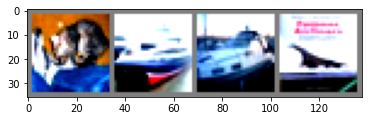

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images[:4]))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [ ]:
outputs = model(images.to(device))

The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship plane


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 86 %


That looks waaay better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 89 %
Accuracy of   car : 95 %
Accuracy of  bird : 77 %
Accuracy of   cat : 70 %
Accuracy of  deer : 84 %
Accuracy of   dog : 79 %
Accuracy of  frog : 92 %
Accuracy of horse : 90 %
Accuracy of  ship : 93 %
Accuracy of truck : 93 %
